# FloydHub Introduction to Deep Learning: Neural Networks

<p align="center">
  <img src="https://media.giphy.com/media/hq7TfiG7jxPTq/source.gif"/>
</p>

## Introduction

Welcome to Part 2! Here, we'll introduce you to the `hello world` of deep learning-- The Handwritten Digit Recognition task. This article is essentially split into two sections, in the first one we pick up where we left off, by implementing a simple logistic regression model on the MNIST data & defining a standard classification workflow. Then we'll (*try*) to build a simple & minimal Neural Network (from scratch) in PyTorch to see how these non-linear architectures improve the classification performance. If you do however feel that the first section is `too simple`, feel free to hop on to the next. So let's get started!

#### Quick Recap

Before we move ahead with our first task of implementing `Logistic Regression` for Digit Recognition, let's quickly mull over what we've done so far:

  1. We introduced PyTorch & some of its basic concepts like Tensors & Variables.
  2. A brief explanation about Autograd & Optimizers.
  3. Introduced the task of Handwritten Digit Recognition on the MNIST dataset.


## Logistic Regression

At the end of last lesson, we introduced the famous MNIST task. It is when we're given a `[28 x 28]` grayscale image of a handwritten digit and we wish to identify the digit `[0-9]`. The outputs here (digits) are referred to as `classes`, 10 of them in this case. This type of problem is particularly known as a **Multi-Class Classification**-- where a response `(y)` can have 3 or more values (10 in this case).

<p align="center">
<img src="https://cdn-images-1.medium.com/max/800/1*zY1qFB9aFfZz66YxxoI2aw.gif"/>
</p>

We'll start off by understanding the workflow of a classification problem. In the next few sections you'll see how an image dataset is processed as well as the instantiation of a Logistic model in PyTorch.

For the sake of notation, let's denote the input image matrix `[28 x 28]` by `X` or `features` & the digit associated with that image as `Y` or `class label`.



#### *Step 1: Feature & Label Transformation*

We can convert the 2-dimensional image features in our example into a 1-dimensional one (as required in linear regression) by appending each row of pixels one after another to the end of the first row of pixels as shown below.

<p align="center">
<img src="https://cdn-images-1.medium.com/max/1000/1*UDgDe_-GMs4QQbT8UopoGA.png"/>
</p>

Also, in a classification task, we cannot leave `Y` as a scalar value since we do not want the predicted outcome to be a real valued number.

To overcome this, the prediction from the model, `Y` should be transformed into a single column vector (shown below as row vector to conserve space) where each element represents the score of what the our classification model thinks is likely to be a particular class. In the example below, `class ‘1’` is the predicted class since it has the highest score.

![Predicted Outcome Transformation](https://cdn-images-1.medium.com/max/1280/1*Ld1fM5euVXm16mTf-4ifZA.png)

To derive this vector of scores, for a given image, each pixel on it will contribute to a set of scores (one for each class) indicating the *likelihood* by which it thinks the image is in a particular class. The sum of all the scores from every pixel for each class becomes the prediction vector.

![Predicted Outcome Transformation 2](https://cdn-images-1.medium.com/max/1280/1*aOP0s2i587kDJW2Td7GNqQ.png)

#### *Step 2: Cost Optimization*

If you remember, in the last article, we had defined our error/loss as `error = (y_-y).abs()` i.e the absolute numerical difference between the predicted output & the actual output. However, in a classification task, things are a bit different. Such a cost function, for an image of digit ‘1’, will penalize a prediction of ‘7’ more heavily `(7–1=6)` than a prediction of ‘2’ `(2–1=1)`, although both are equally wrong.

The most commonly used cost function in multi-class classification problem is the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss. It works in 3 simple steps,

  1. Convert actual image class vector `(y)` into a [one-hot vector](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which is a probability distribution.
  2. Convert prediction class vector `(y')` into a probability distribution using [Softmax](https://www.quora.com/What-is-the-sigmoid-function-and-what-is-its-use-in-machine-learnings-neural-networks-How-about-the-sigmoid-derivative-function).
  3. Calculate the difference between 2 probability distribution functions.

To know more about the intricate functioning of Logistic Regression, read all about it in [this article](https://medium.com/all-of-us-are-belong-to-machines/gentlest-intro-to-tensorflow-4-logistic-regression-2afd0cabc54) by Soon Hin Khor.

### Handling the Data

The `torchvision` package in PyTorch consists of popular datasets, model architectures, and common image transformations for computer vision. `torchvision.datasets` provide a great API to handle the MNIST dataset. The snippet of code below, will create the MNIST dataset, then we will dive into to take a look about MNIST samples.

First of all we import all the packages we need for running this tutorial:

- `torch`, our DL framework
- `torchvision`, package to handle pytorch Dataset for computer vision task
- `torch.nn`, package we need to create our Models
- `numpy` package to handle vector representation
- `matplotlib` to plot graphs

In [1]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# CUDA?
cuda = torch.cuda.is_available()

# Seed for replicability
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


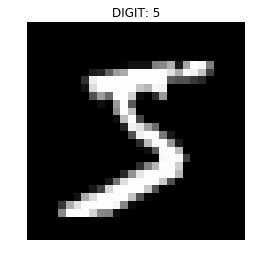

In [2]:
# MNIST Dataset (Images and Labels)
# If you have not mounted the dataset, you can download it
# just adding download=True as parameter

# Get dataset and labels for training
train_dataset = dsets.MNIST(root='/input', 
                            train=True, 
                            transform=transforms.ToTensor())
x_train_mnist, y_train_mnist = train_dataset.train_data.type(torch.FloatTensor), train_dataset.train_labels

# Get dataset and labels for test
test_dataset = dsets.MNIST(root='/input', 
                           train=False, 
                           transform=transforms.ToTensor())
x_test_mnist, y_test_mnist = test_dataset.test_data.type(torch.FloatTensor), test_dataset.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

# Show a sample
plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.axis('off')
plt.show()

`torch.utils.data.DataLoader` combines a dataset and a sampler, and provides single or multi-process iterators over the dataset.

In [3]:
# Hyperparameter
batch_size = 8

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Show a Batch size of sample.

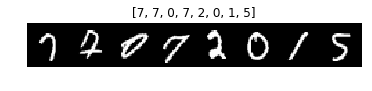

In [4]:
# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
trainset_iter = iter(train_loader)
images, labels = trainset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

In [5]:
# Hyperparameter
batch_size = 64 # To reduce Variance

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Build & Train

Now that we have our image-label pairs in order & ready to be processed in batches of 64 `(batch size)`, we can move ahead and define a standard logistic classifier with `CrossEntropy` loss.

In [58]:
# Hyperparameters
input_size = 784 # 28 * 28
num_classes = 10
learning_rate = 1e-3

#### Weight Init ####
# See Exercices at the end of the Notebook

#### Model ####
# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes) # Define linear, y = x.W + b where W is weight matrix

    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()


#### Loss and Optimizer ####
# Softmax is internally computed.
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()

# Set parameters to be updated.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

And to iterate over the entire dataset to train on the above model architecture over 5 epochs,

In [59]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 2.1838, Accuracy: 32.8125
Epoch: [1/5], Step: [200/937], Loss: 2.1039, Accuracy: 51.5625
Epoch: [1/5], Step: [300/937], Loss: 2.0263, Accuracy: 60.9375
Epoch: [1/5], Step: [400/937], Loss: 1.9046, Accuracy: 68.7500
Epoch: [1/5], Step: [500/937], Loss: 1.8845, Accuracy: 62.5000
Epoch: [1/5], Step: [600/937], Loss: 1.7673, Accuracy: 70.3125
Epoch: [1/5], Step: [700/937], Loss: 1.7025, Accuracy: 68.7500
Epoch: [1/5], Step: [800/937], Loss: 1.6299, Accuracy: 75.0000
Epoch: [1/5], Step: [900/937], Loss: 1.6878, Accuracy: 67.1875
Epoch: [2/5], Step: [100/937], Loss: 1.5276, Accuracy: 76.5625
Epoch: [2/5], Step: [200/937], Loss: 1.4900, Accuracy: 71.8750
Epoch: [2/5], Step: [300/937], Loss: 1.4223, Accuracy: 68.7500
Epoch: [2/5], Step: [400/937], Loss: 1.4780, Accuracy: 65.6250
Epoch: [2/5], Step: [500/937], Loss: 1.3670, Accuracy: 82.8125
Epoch: [2/5], Step: [600/937], Loss: 1.2659, Accuracy: 79.6875
Epoch: [2/5], Step: [700/937], Loss: 1.2725, Accuracy: 

After training is used to plot the Loss and Accuracy given time:

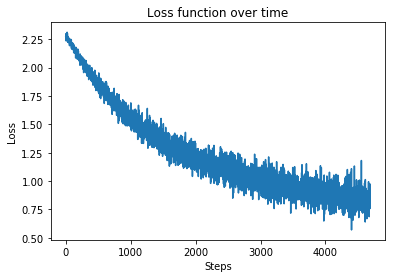

In [60]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

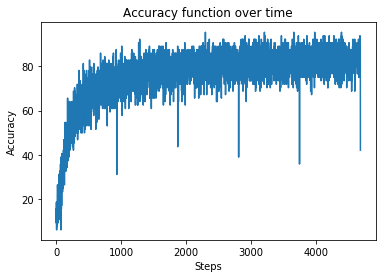

In [61]:
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

We encourage you to try tinkering with the hyperparamters to retrain the whole thing yourself and see what improvements you might get. You may as well want to try out different optimizers!

## Evaluate

Let's evaluate our model on test set.

In [62]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data.view(-1, 28*28), volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 84.32%


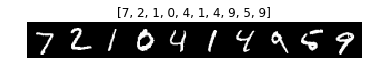

In [34]:
# Test Label

# Hyperparameter
batch_size = 10

# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
testset_iter = iter(test_loader)
images, labels = testset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

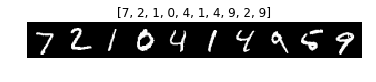

In [35]:
# Result from Training

input = Variable(images.view(-1, 28*28), volatile=True)
if cuda:
    input = input.cuda()
output = model(input)
# Load output on CPU
if cuda:
    output.cpu()
    
plt.axis('off')
imshow(batch_imgs, title=[x for x in output.data.max(1)[1]])

## Artificial Neural networks

So until now, you've seen how a machine **learns** by reiterating over the input data over & over & minimizing a `loss` function. Neural Networks behave much in the same way but are **structurally** different from linear models like Logistic Regression. Neural Networks tend to introduce a **non-linearity** in the form a mathematical transformation as the input data is processed. What we want you to do here now is, compare the following snippet of code below to the one defined above for Logistic Regression,

```python
model = nn.Sequential(
    nn.Linear(D_in, H), #Layer 1 : Input Layer
    nn.ReLU(), # Activation Function
    nn.Linear(H, D_out), # Layer 3 : Output Layer
)
```
Do you see any difference? Instead of simply creating a linearized equation i.e `y = W.x + b`, our equation will be of the form, `y = W.(ReLU(W_.x + b_) + b)`. It is interesting to know that `H` here represents the **hidden weights** or intermediate values while `ReLU` or [Rectified Linear Unit](https://en.wikipedia.org/wiki/Ramp_function) is the introduced non-linearity. This brief introduction to Neural Nets will about their structural component & not the historical motivations behind them. However, if you do wish to explore more about vanilla neural network architecture, Keno Leon does a fantastic job of explaining them through his doodles in [this medium article](https://becominghuman.ai/making-a-simple-neural-network-2ea1de81ec20).

For the time being, let's just say a **Neuron** is something that holds a real valued number. And for the task at hand, we have 784 `[28 x 28]` of these Neurons as input. Let's call the values held by these Neurons as thier **Activations** & represent how positive or negative is the relevant weighted sum of inputs to that Neuron is, as the data flows through the network. These 784 Neurons make up the first layer of our network.

<p align="center">
<img src="https://ml4a.github.io/images/figures/mnist_1layer.png"/>
</p>

Similar to Logistic Regression, the last layer in the network is simply a vector of 10 Neurons holding Activations that represent the **probability** of an image belonging to a particular class; in this case, a digit. Remember, activations in one layer determine activations in the next layer.

**So what are hidden layers for?** Our best hope with a non-linear layered architecture is that specific Neurons in each layer of the network are able to detect certain patters in the input data & get activated accordingly. That is to say, certain Neurons in Hidden Layer 1 might be activated by straight lines, some other Neurons in Hidden Layer 2 might get activated by by contours. Imagine how detecting shapes & contours might be helpful for image recognition tasks. Even the task of parsing speech breaks down into layers of abstraction i.e distinct sounds to words to sentences to phrases to thoughts!

<p align="center">
<img src= "http://neuralnetworksanddeeplearning.com/images/tikz12.png"/>
</p>

Each Neuron in the hidden layer is connected to all 784 pixel Nuerons from the input layer. And each of those 784 connections have their own weights & some [biases](https://stackoverflow.com/questions/2480650/role-of-bias-in-neural-networks). So for 16-Neuron hidden layer, we have `784 x 16 + 16` weights and biases. And the learning process tends to find the right balance of weights & biases so that it solves the problem at hand. And that's just the first Hidden Layer! See why we need all that GPU compute we spoke about in the introduction?

### Let's Get Started!

Now that we've defined in some detail how a neural network functions, let's code a simple one in PyTorch & see how well it does on the MNIST task.

In [6]:
# Hyperparameters
input_size = 784 # 28 * 28
hidden_size = 16 #Something you can experiment with
num_classes = 10 # Output classes
learning_rate = 1e-3

#### Weight Init ####
# See Exercices at the end of the Notebook


#### Model ####
# One Hidden Layer Neural Network Model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Feed in Matrix of Dim [784 x 16]
        self.relu = nn.ReLU() # max(fc1(x),0)
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output's Dim [16 x 10]
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = Net(input_size, hidden_size, num_classes)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()  
    
#### Loss and Optimizer ####
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()

# Feeding model params to the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The snippet above defines a simple single layer neural network with a forward pass on the input with Cross Entropy Loss as the loss function. Training is very similar to what we did in the first section of the article,

In [7]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 0.9907, Accuracy: 78.1250
Epoch: [1/5], Step: [200/937], Loss: 0.6148, Accuracy: 81.2500
Epoch: [1/5], Step: [300/937], Loss: 0.5220, Accuracy: 85.9375
Epoch: [1/5], Step: [400/937], Loss: 0.4350, Accuracy: 85.9375
Epoch: [1/5], Step: [500/937], Loss: 0.2748, Accuracy: 92.1875
Epoch: [1/5], Step: [600/937], Loss: 0.5882, Accuracy: 84.3750
Epoch: [1/5], Step: [700/937], Loss: 0.3247, Accuracy: 92.1875
Epoch: [1/5], Step: [800/937], Loss: 0.2954, Accuracy: 90.6250
Epoch: [1/5], Step: [900/937], Loss: 0.1762, Accuracy: 96.8750
Epoch: [2/5], Step: [100/937], Loss: 0.4476, Accuracy: 90.6250
Epoch: [2/5], Step: [200/937], Loss: 0.3355, Accuracy: 87.5000
Epoch: [2/5], Step: [300/937], Loss: 0.2315, Accuracy: 96.8750
Epoch: [2/5], Step: [400/937], Loss: 0.3259, Accuracy: 93.7500
Epoch: [2/5], Step: [500/937], Loss: 0.1926, Accuracy: 95.3125
Epoch: [2/5], Step: [600/937], Loss: 0.3357, Accuracy: 92.1875
Epoch: [2/5], Step: [700/937], Loss: 0.4145, Accuracy: 

After training is used to plot the Loss and Accuracy given time:

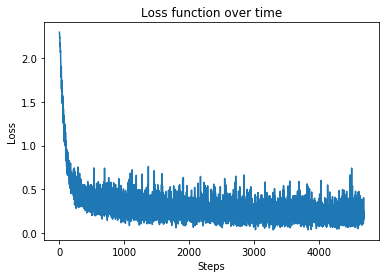

In [8]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

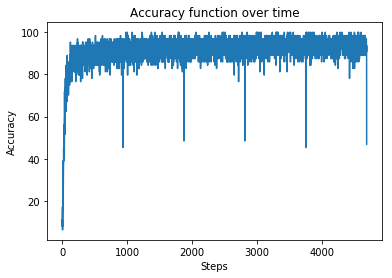

In [9]:
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

We train our model for five epochs by feeding in `image , label` pairs, doing a forward pass over the image with initial weights of the Neurons & then backpropagating through gradient computation to update those weights with the help of an optimizer (Adam), to make the model more & more accurate after each iteration.

## Evaluate

Let's evaluate our model on test set.

In [10]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data.view(-1, 28*28), volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 93.89%


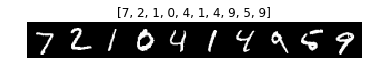

In [70]:
# Test Label

# Hyperparameter
batch_size = 10

# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
testset_iter = iter(test_loader)
images, labels = testset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

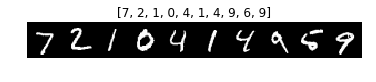

In [50]:
# Result from Training

input = Variable(images.view(-1, 28*28), volatile=True)
if cuda:
    input = input.cuda()
output = model(input)
# Load output on CPU
if cuda:
    output.cpu()
    
plt.axis('off')
imshow(batch_imgs, title=[x for x in output.data.max(1)[1]])

### Results: Neural Network

As you can see, with a test accuracy of 97%, a simple Neural Network far outweighs the Logistic Regression! Imagine what we could possibly do if we had a dedicated Neural Network architecture for processing images (and we do!).

### NN Experiments Exercices

ML/DL is empiric field, so let' make some experiments and see how the loss and accuracy change tuning different hyperparameters:

#### Change Weight Init

Most of the time providing a good staring point in an Optimization problem is half of the work, so take the Logistic Regression Model and init the weight with Xavier initialization and bias from a Uniform distribution

Define this function befor the model 
```python
# Xavier Uniform Init
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data)
        nn.init.uniform(m.bias.data)
```
Then apply the weight init after builiding the model with

```python
model = Model() # generate an instance model from the Model class
model.apply(weights_init) # apply weight init
```

This experiments should provide an accuracy about 83.3% for LR and about 94.7% for NN. Not bad, but we have not improved the baseline for LR which was about 84.3%, while we have improved the NN baseline of 0.7% points.

#### Try Swish or others Activation Functions

What if we change ReLu with swish, sigmoid or tanh? Even the activation function can dramatically change the training, first of all replace ReLu with Sigmoid, then with tanh and finally with Swish.

Sigmoid | Tanh | ReLU | Swish
--------|------|------|------
92.84% | 94.21% | 93.89% | 94.42%

At this writing PyTorch does not provide Swish natively so you have to create a new Class which inherit from torch.autograd.Function and define 2 method, one for the forward step and the other one for the backward step. We have provided to you the Swish class, you have only to adapt the model.

```pyhton
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i*i.sigmoid()
        ctx.save_for_backward(result,i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        result,i = ctx.saved_variables
        sigmoid_x = i.sigmoid()
        return grad_output * (result+sigmoid_x*(1-result))
        
...


class YourModel(nn.Module):
    # create a Swish instance
    def __init__(self, ..):
        ...
        self.swish = Swish.apply
        ...
    # Compute the forward pass
    def forward(self, ..):
        ...
        out = self.swish(x)
        ...
    
```

About sigmoid and tanh you have to define the nn.functional.tanh/sigmoid step in the forward function.

#### Add more layers or change the number of units in the hidden layer

Replace the number of hidden units in the hidden layer with 50, the accuracy should be around 96.78%. In this way we are improving the model capacity. Same will happen if we add more layers! Keep in mind that having a more deeper model can also increase the chance to overfit and degrade the generalization peformance of the model


## Summary

That's all for now. Now it's your turn to experiment with this simple network architecture by adding more layers, optimizers or maybe experiment with [regualizers](https://en.wikipedia.org/wiki/Overfitting). It may not seem much at first, but if you've followed along thoroughly & implemented the aforementioned task yourself, you've learned a lot! In the next couple of articles we'll be covering slightly advanced concepts related to Deep Learning & you'll see some of the most powerful applications of it in action. Stay tuned!

## Next Up: Convolutional Neural Network

<p align="center">
<img src="https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/_jcr_content/mainParsys/image.img.jpg/1508999490105.jpg"/>
</p>

CNNs represent the best of Deep Learning in Computer Vision. They have wide applications is image & video recognition, recommender systems & natural language processing. In the next article we'll cover the basics of CNN & see how they boost state-of-the-art results in image classification. Since CNNs are slightly more complex than generic multi-layer perceptrons we've built until now, if you feel curious, you can read about them on [Christopher Olah's blog](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) before moving on & implementing one with us on your own.